# Investigating molecular blood-brain-barrier permeability

**Lab Final Project**<br>
**PHYSCI 2 at Harvard College**<br>
**Ayush Noori, Aditi Raju, Jared Ni**<br>

# Introduction

The blood-brain-barrier (BBB) is a selective semipermeable membrane that separates circulating blood from the brain and extracellular fluid in the central nervous system, and is responsible for regulation of CNS homeostasis and protection of the brain microenvironment from toxins, pathogens, and other threats (Daneman & Prat, 2015; Obermeier et al., 2013). At every level of the neurovascular tree, endothelial cells of the BBB line the capillaries and are surrounded by pericytes, astrocytes, microglia, extracellular matrix components, and peripheral immune cells, which together form the neurovascular unit (Iadecola, 2017). The physical properties of the neurovascular unit – most importantly, the continuous tight junctions which connect the non-fenestrated endothelial cells – restrict the paracelllular and transcellular movememnt of molecules from the bloodstream into the brain (Figure 1) (Abbott et al., 2010; Langen et al., 2019). Other key features of the BBB which govern passage into the brain include specific molecular transporters which facilitate both the influx of nutrients and the efflux of toxins; catalytic enzymes such as intracellular monoamine oxidase and cytochrome P450 which degrade potential toxins; and extravascular structures such as the endothelial glycocalyx and astrocytic endfeet which modulate BBB function (Abbott et al., 2006; Daneman & Prat, 2015; Langen et al., 2019).

<img src="figures/figure_1.png" alt="Figure 1: Transport regulatory functions of the blood-brain-barrier." width="100%">

**Figure 1: Transport regulatory functions of the blood-brain barrier.** Figure from [ayushnoori/graph-bbb](https://github.com/ayushnoori/graph-bbb) on GitHub and created using Biorender.com.

In addition to regulating the passage of nutrients into the brain and protecting the brain microenvironment from invaders or pathogens, the BBB also prevents more than 98% of small molecule drugs and macromolecular therapeutics from reaching the brain. This poses a major obstacle in the treatment of neurological disorders which often remain refractory to treatment due to the inability of drugs to cross the BBB (Wu et al., 2023). The BBB is therefore a major target of drug delivery research, and understanding the permeability of molecules to the BBB is of great interest to facilitate the development of new neurotherapeutics. Our own previous work has attempted to predict BBB permeability (for example, see [ayushnoori/graph-bbb](https://github.com/ayushnoori/graph-bbb) on GitHub), but this has been limited by lack of molecular diversity and interpretability. In this project, we aim to investigate the relationship between molecular structure and BBB permeability using a structurally diverse dataset of 1058 compounds with known BBB permeabilities. 

# Research Question

Here, we investigate the relationships between BBB permeability and molecular properties such as molecular weight, number of hydrogen bond donors and acceptors, number of rotatable bonds, and number of rings. 

# Methodology and Results

We use techniques learned during the Fall 2023 semester in PHYSCI 2 Lab at Harvard College to investigate the relationships between molecular properties of interest and BBB permeability. We leverage a new diverse molecular database of BBB permeability with chemical descriptors, recently published in *Nature Scientific Data* in 2021:

Meng, F., Xi, Y., Huang, J. & Ayers, P. W. [A curated diverse molecular database of blood-brain barrier permeability with chemical descriptors.](https://www.nature.com/articles/s41597-021-01069-5) *Sci Data* **8**, 289 (2021).

Please also see [theochem/B3DB](https://github.com/theochem/B3DB) and [Issue #174 of mims-harvard/TDC](https://github.com/mims-harvard/TDC/issues/174) on GitHub. After retrieving and pre-processing our data, we calculate several molecular features of 1058 compounds as well as numerical logBB values for each compound, where logBB is the logarithm of the brain-plasma concentration ratio:
$$\log{BB} = \log{\frac{C_{brain}}{C_{blood}}}$$

Then, we apply curve fitting methods learned in Lab 4 and Lab 5 to fit various biologically-informed models to the data. We visualize our data and results and, based on visual inspection, generate hypotheses for relationships between molecular features and logBB. Finally, we use $\chi^2_{red}$-testing to select from multiple competing models of the data and compare the goodness-of-fit of each.

Our experimental design, methodology, and results are described in detail below. First, we load relevant libraries.

In [77]:
# standard imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# molecular manipulation
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors

# clustering
from sklearn.cluster import AgglomerativeClustering

# path manipulation
from pathlib import Path

# import project configuration
import project_config
from lab_functions import *

Next, we read the Meng *et al*. dataset into a `pandas` data frame (Meng *et al.*, 2021). This dataset, known as the Blood-Brain Barrier Database (B3DB) was compiled from more than 50 published resoures and contains BBB permeability data for 1058 compounds. Each row in the date frame corresponds to a unique compound and each column corresponds to a chemical descriptor or logBB value. 

In [78]:
# read in data
# define this as the directory of the cloned project
project_config.PROJECT_DIR = Path("/Users/jaredhn/codespace/ps2-lab")
data = pd.read_csv(project_config.PROJECT_DIR / 'B3DB_regression.tsv', sep='\t')
data.head()

,NO.,compound_name,IUPAC_name,SMILES,CID,logBB,Inchi,reference,group,comments
0,1,moxalactam,7-[[2-carboxy-2-(4-hydroxyphenyl)acetyl]amino]...,CN1C(=NN=N1)SCC2=C(N3C(C(C3=O)(NC(=O)C(C4=CC=C...,3889.0|,-2.52,InChI=1S/C20H20N6O9S/c1-25-19(22-23-24-25)36-8...,R25|,A,NaN
1,2,schembl614298,"(2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-7-hydro...",CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)OC6[C@...,18595497.0|,-2.15,InChI=1S/C23H27NO9/c1-24-7-6-23-10-3-4-12(25)2...,R25|,A,NaN
2,3,morphine-6-glucuronide,"(2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-9-hydro...",CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)O)O[C@...,9847115.0|,-2.09,InChI=1S/C23H27NO9/c1-24-7-6-23-10-3-5-13(31-2...,R25|,A,NaN
3,4,2-[4-(5-bromo-3-methylpyridin-2-yl)butylamino]...,2-[4-(5-bromo-3-methylpyridin-2-yl)butylamino]...,CC1=NC=C(C=C1)CC2CNC(NC2=O)NCCCCC3=NC=C(C=C3C)Br,74041479.0|,-1.88,InChI=1S/C21H28BrN5O/c1-14-9-18(22)13-25-19(14...,R35|,A,NaN
4,5,NaN,NaN,c1(c2c3n(c4c(C(N(C)C3)=O)c(Cl)ccc4)cn2)noc(C(O...,nan|,-1.82,"InChI=1S/C16H14ClN5O4/c1-16(24,25)15-19-13(20-...",R35|,A,NaN


We use the RDKit library to calculate various molecular features from the SMILES structures. Simplied molecular-input line-entry system, or SMILES, is a specification for describing the structure of chemical species using short ASCII strings. RDKit is an open-source cheminformatics toolkit that supports many common tasks in cheminformatics, including molecular property calculation.

Compound Name:  moxalactam


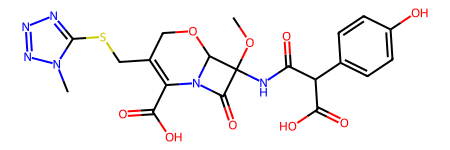

In [79]:
# get molecule from SMILES
data['mol'] = data['SMILES'].apply(Chem.MolFromSmiles)

# visualize first molecule
print("Compound Name: ", data['compound_name'].iloc[0])
data['mol'].iloc[0]

Next, we use the RDKit library to calculate molecular features from SMILES strings. We calculate the following molecular features for each compound:
* Average molecular weight, which reflects the distribution of isotopes of the molecule's atoms.
* Exact molecular weight, which gives the molecular weight of the most common isotopes of each atom in the molecule.
* Average molecular weight excluding hydrogens.
* Number of hydrogen bond acceptors.
* Number of hydrogen bond donors.
* Number of heavy atoms.
* Number of aromatic rings.
* Number of total rings.
* Number of rotatable bonds.

In [80]:
# to calculate all 210 descriptors
# descriptors = data['mol'].apply(lambda x: pd.Series(Chem.Descriptors.CalcMolDescriptors(x)))

# get average molecular weight (MolWt)
data['mol_wt'] = data['mol'].apply(lambda x: Descriptors.MolWt(x))

# get exact molecular weight (ExactMolWt)
data['exact_mol_wt'] = data['mol'].apply(lambda x: Descriptors.ExactMolWt(x))

# get average molecular weight ignoring hydrogens (HeavyAtomMolWt)
data['heavy_atom_mol_wt'] = data['mol'].apply(lambda x: Descriptors.HeavyAtomMolWt(x))

# get average number of hydrogen bond acceptors (NumHAcceptors)
data['num_h_acceptors'] = data['mol'].apply(lambda x: Descriptors.NumHAcceptors(x))

# get average number of hydrogen bond donors (NumHDonors)
data['num_h_donors'] = data['mol'].apply(lambda x: Descriptors.NumHDonors(x))

# get number of heavy atoms (HeavyAtomCount)
data['heavy_atom_count'] = data['mol'].apply(lambda x: Descriptors.HeavyAtomCount(x))

# get number of aromatic rings (NumAromaticRings)
data['num_aromatic_rings'] = data['mol'].apply(lambda x: Descriptors.NumAromaticRings(x))

# get number of rings (NumRings)
data['num_rings'] = data['mol'].apply(lambda x: Descriptors.RingCount(x))

# get number of rotatable bonds (NumRotatableBonds)
data['num_rotatable_bonds'] = data['mol'].apply(lambda x: Descriptors.NumRotatableBonds(x))

# show first 5 rows of data
data.head()

,NO.,compound_name,IUPAC_name,SMILES,CID,logBB,Inchi,reference,group,comments,mol,mol_wt,exact_mol_wt,heavy_atom_mol_wt,num_h_acceptors,num_h_donors,heavy_atom_count,num_aromatic_rings,num_rings,num_rotatable_bonds
0,1,moxalactam,7-[[2-carboxy-2-(4-hydroxyphenyl)acetyl]amino]...,CN1C(=NN=N1)SCC2=C(N3C(C(C3=O)(NC(=O)C(C4=CC=C...,3889.0|,-2.52,InChI=1S/C20H20N6O9S/c1-25-19(22-23-24-25)36-8...,R25|,A,NaN,<rdkit.Chem.rdchem.Mol object at 0x28a8822d0>,520.480,520.101247,500.320,12,4,36,2,4,9
1,2,schembl614298,"(2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-7-hydro...",CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)OC6[C@...,18595497.0|,-2.15,InChI=1S/C23H27NO9/c1-24-7-6-23-10-3-4-12(25)2...,R25|,A,NaN,<rdkit.Chem.rdchem.Mol object at 0x28a881d90>,461.467,461.168581,434.251,9,5,33,1,6,3
2,3,morphine-6-glucuronide,"(2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-9-hydro...",CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)O)O[C@...,9847115.0|,-2.09,InChI=1S/C23H27NO9/c1-24-7-6-23-10-3-5-13(31-2...,R25|,A,NaN,<rdkit.Chem.rdchem.Mol object at 0x28a8823b0>,461.467,461.168581,434.251,9,5,33,1,6,3
3,4,2-[4-(5-bromo-3-methylpyridin-2-yl)butylamino]...,2-[4-(5-bromo-3-methylpyridin-2-yl)butylamino]...,CC1=NC=C(C=C1)CC2CNC(NC2=O)NCCCCC3=NC=C(C=C3C)Br,74041479.0|,-1.88,InChI=1S/C21H28BrN5O/c1-14-9-18(22)13-25-19(14...,R35|,A,NaN,<rdkit.Chem.rdchem.Mol object at 0x28a881f50>,446.393,445.147723,418.169,5,3,28,2,3,8
4,5,NaN,NaN,c1(c2c3n(c4c(C(N(C)C3)=O)c(Cl)ccc4)cn2)noc(C(O...,nan|,-1.82,"InChI=1S/C16H14ClN5O4/c1-16(24,25)15-19-13(20-...",R35|,A,NaN,<rdkit.Chem.rdchem.Mol object at 0x28a881ee0>,375.772,375.073432,361.660,8,2,26,3,4,2


We visualize the relationship between molecular weight and logBB. Note that the logBB is the logarithm of the ratio of the concentration of the compound in the brain to the concentration in the plasma. 
$$\log{BB} = \log{\frac{C_{brain}}{C_{blood}}}$$

If the logBB is positive, then a compound is BBB-permeable and vice versa.

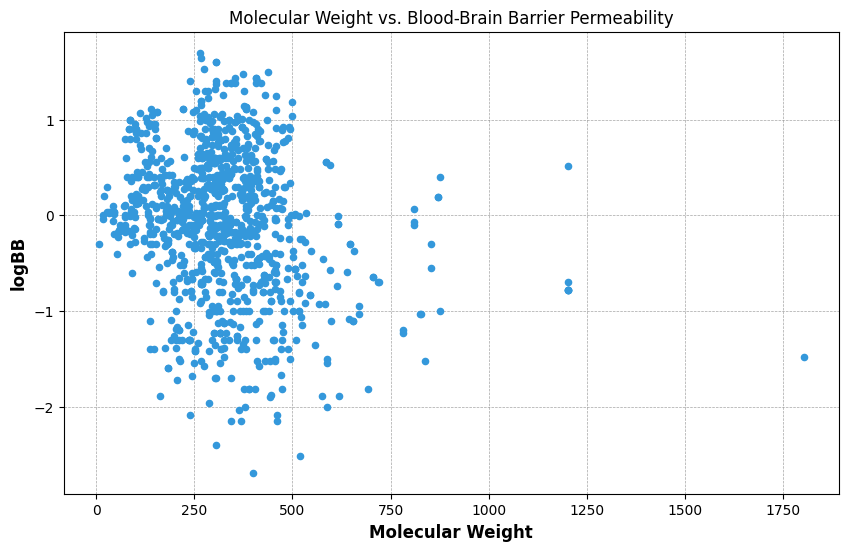

In [81]:
# create function to plot data
def make_scatter(data, x, y, xlabel, ylabel, title = None, color = '#3498db'):

    # create title
    if title is None:
        title = xlabel + ' vs. ' + ylabel

    # set figure dimensions
    plt.figure(figsize=(10, 6))

    # plot data points
    plt.scatter(data[x], data[y], s=20, color=color)

    # set title and axis labels
    plt.title(title)
    plt.xlabel(xlabel, fontweight='bold', size=12)
    plt.ylabel(ylabel, fontweight='bold', size=12)

    # add a gray dashed grid in the background
    plt.grid(axis = "both", color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.gca().set_axisbelow(True)

    # return plot
    return plt

# plot molecular weight vs. logBB
plt = make_scatter(data, 'mol_wt', 'logBB', 'Molecular Weight', 'logBB', title = 'Molecular Weight vs. Blood-Brain Barrier Permeability')
plt.show()

Since we seek to perform $\chi^2_{red}$-testing, we require uncertainties for our measurements. The most important uncertainty to account for is not in the molecular weight; rather, there is biological uncertainty in logBB, or the measured brain-plasma concentration ratio. However, the B3DB database does not provide uncertainties. Therefore, we must compute a proxy uncertainty measurement.
 
Since we are not provided with uncertainties on logBB, we cluster molecules by molecular similarity (*e.g.*, Morgan fingerprint), motivated by the underlying biological assumption that compounds with highly similar molecular structures and properties would also have highly similar brain-plasma concentration ratios. Thus, for the purposes of uncertainty estimation, we treat molecules within the same cluster as equivalent observations, and take the standard error of logBB values within each cluster as the uncertainty on logBB for that cluster.

First, we use the RDKit library to calculate Morgan fingerprints for each compound. Morgan fingerprints, also known as extended-connectivity fingerprint ECFP4, are a type of circular fingerprint, which encode the local chemical environment of a molecule by iteratively applying a hashing function to a molecule's substructures. Here, we use a radius of 2, which means that the hashing function is applied to all substructures within 2 bonds of each atom in the molecule, and a bit length of 1024.   

In [82]:
# compute fingerprints
data['fingerprints'] = data['mol'].apply(lambda x: Chem.AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024))

# convert to numpy arrays
np_fingerprints = []
for fp in data['fingerprints']:
    array = np.zeros((0, ), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, array)
    np_fingerprints.append(array)

Next, we perform clustering on the Morgan fingerprints to group molecules by molecular similarity. We use agglomerative clustering, whcih recursively merges pairs of clusters based on the linkage distance between the clusters; in this case, we use the Ward linkage criterion, which minimizes the variance of the clusters being merged.

In [83]:
# perform hierarchical clustering
num_clusters = 50  # You can adjust the number of clusters
clustering = AgglomerativeClustering(n_clusters = num_clusters, metric = 'euclidean', linkage = 'ward')
cluster_labels = clustering.fit_predict(np_fingerprints)

We assign cluster identity to each compound and visualize molecules from the same cluster to confirm the structural similarity between the molecules.

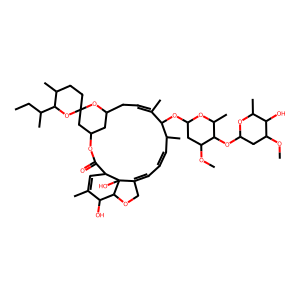

In [84]:
# assign cluster identity
data['cluster'] = cluster_labels

# within each cluster, compute SEM of logBB
cluster_summary = data.groupby('cluster')['logBB'].agg(['mean', 'sem'])

# assign mean and SEM to all molecules by cluster
data = data.merge(cluster_summary, left_on = 'cluster', right_index = True)

# we visualize molecules of cluster 40
Chem.Draw.MolToImage(data[data['cluster'] == 40]['mol'][30])

Plot a second molecule from cluster 40 to demonstrate that the clustering is reasonable.

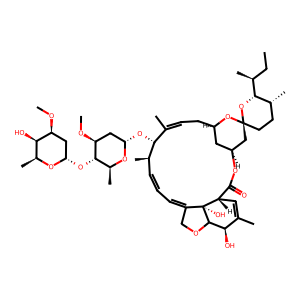

In [85]:
# plot second molecule
Chem.Draw.MolToImage(data[data['cluster'] == 40]['mol'][178])

Finally, we plot a histogram of the uncertainties.

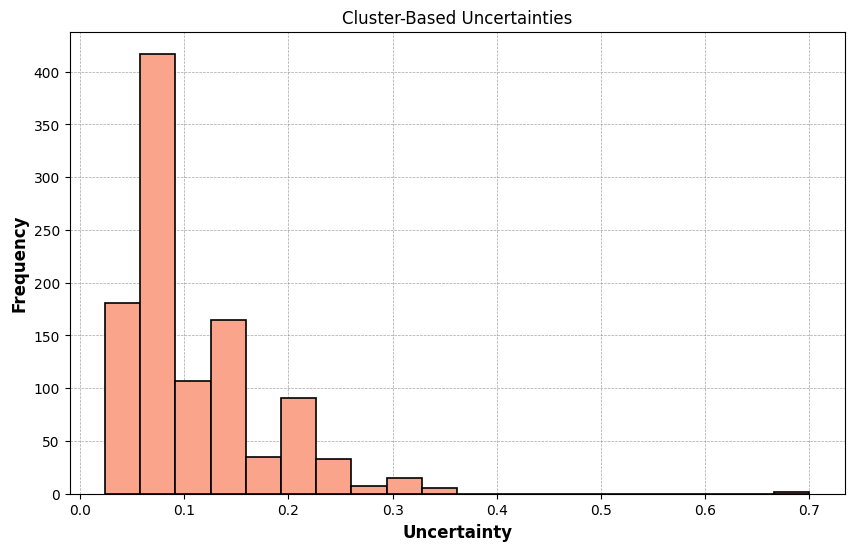

In [86]:
# set figure dimensions
plt.figure(figsize=(10, 6))

# plot data points
plt.hist(data['sem'], bins = 20, color = '#F9A48B', edgecolor = 'black', linewidth = 1.2)

# set title and axis labels
plt.title('Cluster-Based Uncertainties')
plt.xlabel('Uncertainty', fontweight='bold', size=12)
plt.ylabel('Frequency', fontweight='bold', size=12)

# add a gray dashed grid in the background
plt.grid(axis = "both", color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.gca().set_axisbelow(True)

Next, we fit a linear model to the data.

Best Fit Parameters:

	 Independent Variable: Molecular Weight
	 Dependent Variable: logBB
	 Model: Linear Model
	 P1 =  -0.00147 +/- 2e-05
	 P2 =  0.32189 +/- 0.00468

 Fit Metrics:

	 Degrees of freedom (N-d):  1056
	 Reduced Chi Squared = 66.752

Best Fit Parameters:

	 Independent Variable: Molecular Weight
	 Dependent Variable: logBB
	 Model: Quadratic Model
	 P1 =  -0.0 +/- 0.0
	 P2 =  -0.00111 +/- 4e-05
	 P3 =  0.27563 +/- 0.00658

 Fit Metrics:

	 Degrees of freedom (N-d):  1055
	 Reduced Chi Squared = 66.721

Best Fit Parameters:

	 Independent Variable: Molecular Weight
	 Dependent Variable: logBB
	 Model: Logarithmic Model
	 P1 =  -0.25187 +/- 0.00338
	 P2 =  1.29096 +/- 0.01826

 Fit Metrics:

	 Degrees of freedom (N-d):  1056
	 Reduced Chi Squared = 69.863

Best Fit Parameters:

	 Independent Variable: Molecular Weight
	 Dependent Variable: logBB
	 Model: Reciprocal Model
	 P1 =  1.33221 +/- 0.20458

 Fit Metrics:

	 Degrees of freedom (N-d):  1057
	 Reduced Chi Squared = 

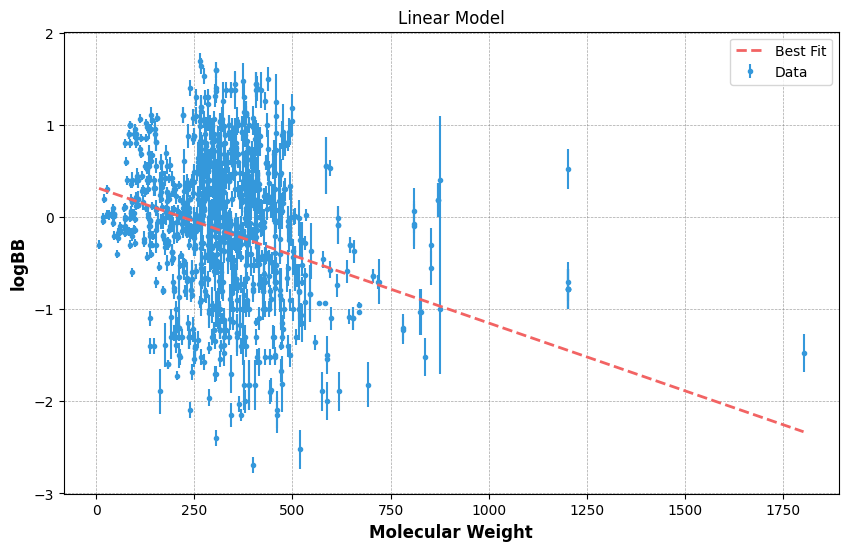

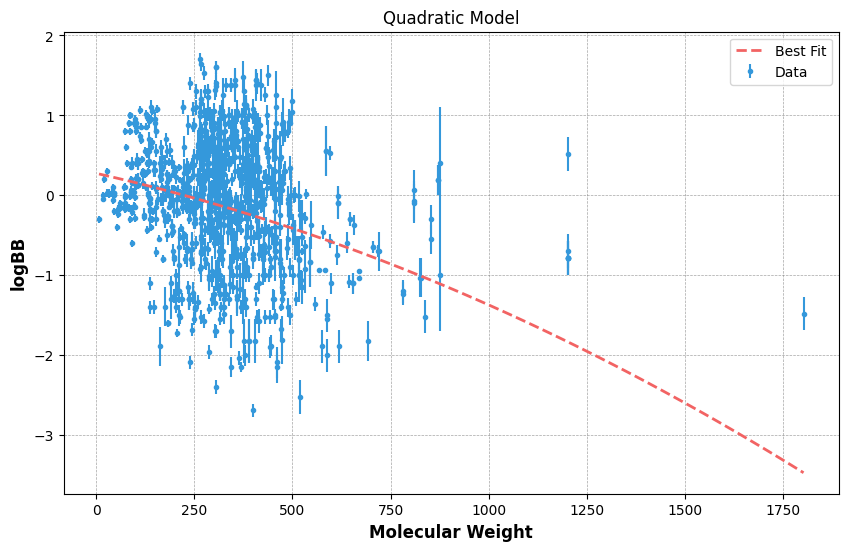

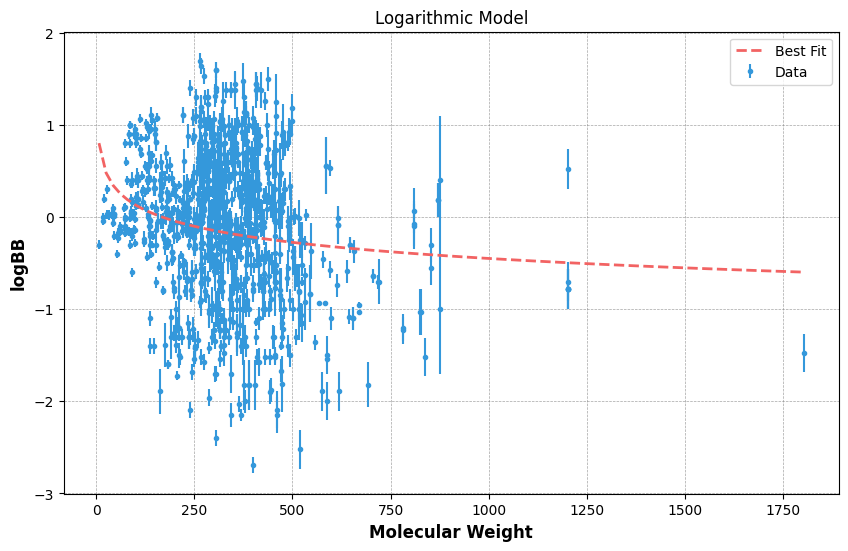

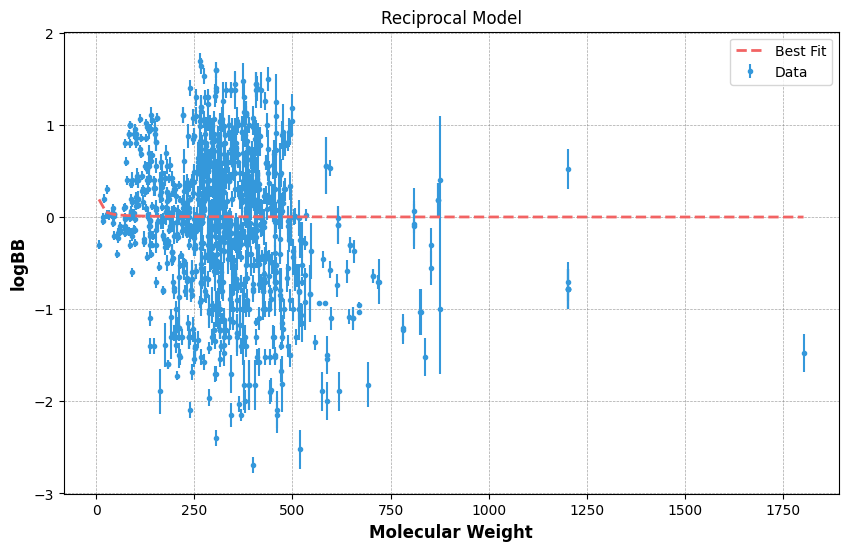

In [87]:
# subset columns
x_value = data['mol_wt'].to_numpy()
y_value = data['logBB'].to_numpy()
y_error = data['sem'].to_numpy()

# define linear model
def linear_model(x, slope, y_int):
  y = x*slope + y_int 
  return y

# define quadratic model
def quadratic_model(x, a, b, y_int):
  y = a * x**2 + b*x + y_int 
  return y

# define logarithmic model
def logarithmic_model(x, a, y_int):
  y = a * np.log(x + 0.000001) + y_int 
  return y

# define 
def reciprocal_model(x, a):
  y = a / (x + 0.000001)
  return y

# fit linear and quadratic models
fitparams, fiterrs = mycurvefit(linear_model, x_value, y_value, y_error, 'Molecular Weight', 'logBB', title='Linear Model', plot=True)
fitparams, fiterrs = mycurvefit(quadratic_model, x_value, y_value, y_error, 'Molecular Weight', 'logBB', title='Quadratic Model', plot=True)
fitparams, fiterrs = mycurvefit(logarithmic_model, x_value, y_value, y_error, 'Molecular Weight', 'logBB', title='Logarithmic Model', plot=True)
fitparams, fiterrs = mycurvefit(reciprocal_model, x_value, y_value, y_error, 'Molecular Weight', 'logBB', title='Reciprocal Model', plot=True)

We repeat the linear and quadratic fits for other variables of interest.

Best Fit Parameters:

	 Independent Variable: Heavy Atom Count
	 Dependent Variable: logBB
	 Model: Linear Model
	 P1 =  -0.02004 +/- 0.00021
	 P2 =  0.29819 +/- 0.00448

 Fit Metrics:

	 Degrees of freedom (N-d):  1056
	 Reduced Chi Squared = 66.854

Best Fit Parameters:

	 Independent Variable: Heavy Atom Count
	 Dependent Variable: logBB
	 Model: Quadratic Model
	 P1 =  -0.00011 +/- 1e-05
	 P2 =  -0.01487 +/- 0.00053
	 P3 =  0.25436 +/- 0.00608

 Fit Metrics:

	 Degrees of freedom (N-d):  1055
	 Reduced Chi Squared = 66.81

Best Fit Parameters:

	 Independent Variable: Heavy Atom Count
	 Dependent Variable: logBB
	 Model: Logarithmic Model
	 P1 =  -0.22338 +/- 0.00306
	 P2 =  0.53252 +/- 0.00844

 Fit Metrics:

	 Degrees of freedom (N-d):  1056
	 Reduced Chi Squared = 70.088

Best Fit Parameters:

	 Independent Variable: Heavy Atom Count
	 Dependent Variable: logBB
	 Model: Reciprocal Model
	 P1 =  0.13013 +/- 0.01338

 Fit Metrics:

	 Degrees of freedom (N-d):  1057
	 Reduced Chi S

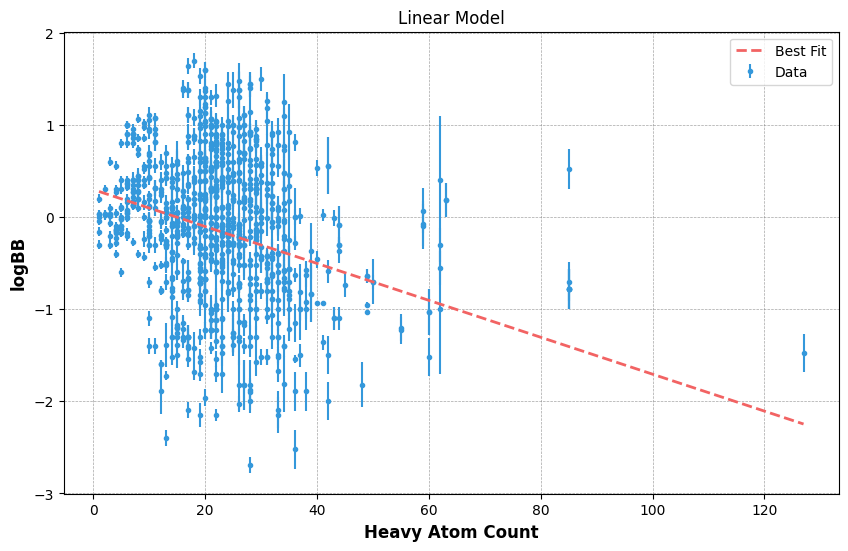

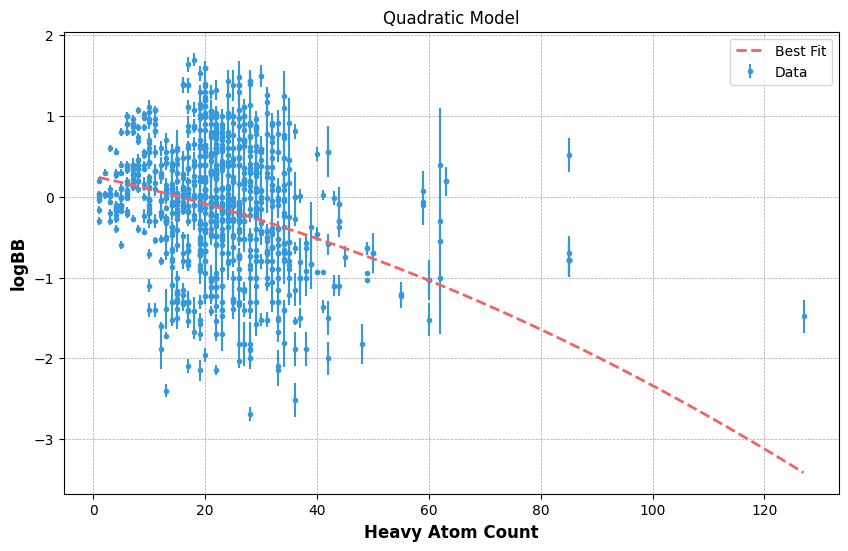

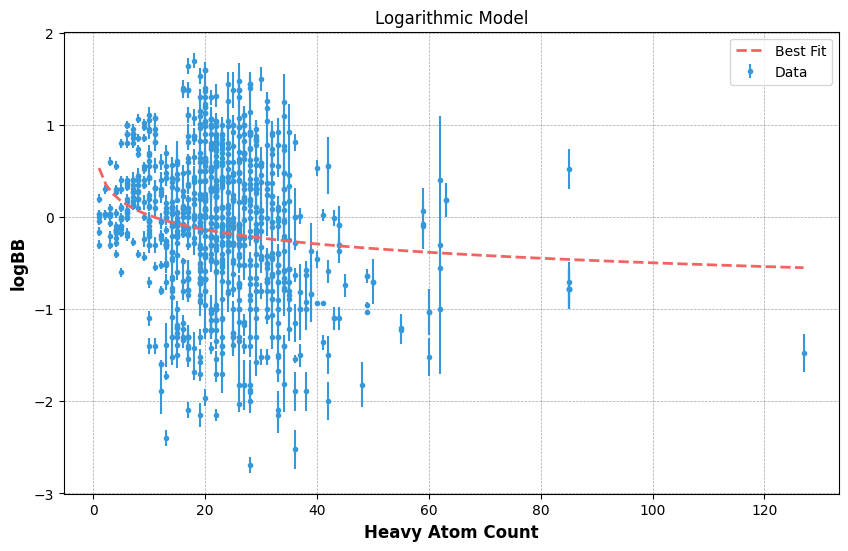

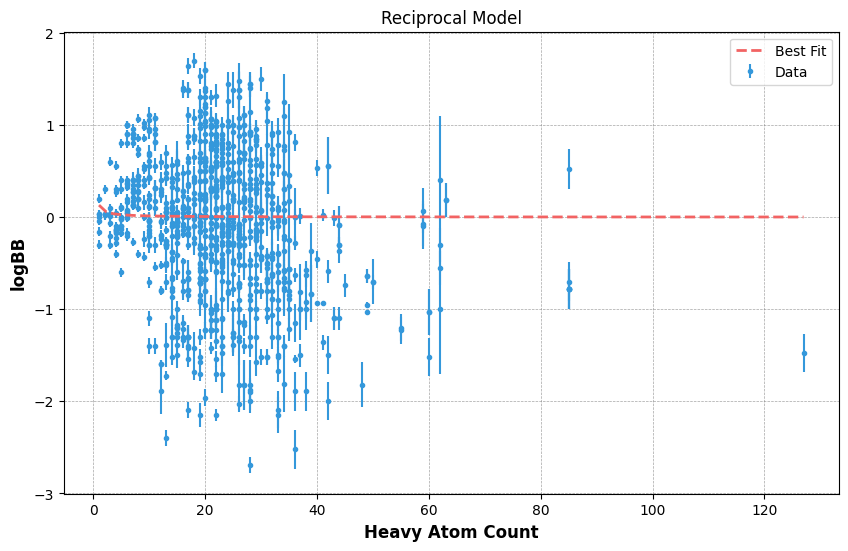

In [88]:
# fit models to logBB vs. heavy atom count
x_value = data['heavy_atom_count'].to_numpy()
tparams, fiterrs = mycurvefit(linear_model, x_value, y_value, y_error, 'Heavy Atom Count', 'logBB', title='Linear Model', plot=True)
fiarams, fiterrs = mycurvefit(quadratic_model, x_value, y_value, y_error, 'Heavy Atom Count', 'logBB', title='Quadratic Model', plot=True)
fitparams, fiterrs = mycurvefit(logarithmic_model, x_value, y_value, y_error, 'Heavy Atom Count', 'logBB', title='Logarithmic Model', plot=True)
fitparams, fiterrs = mycurvefit(reciprocal_model, x_value, y_value, y_error, 'Heavy Atom Count', 'logBB', title='Reciprocal Model', plot=True)

We repeat this process for number of rings.

Best Fit Parameters:

	 Independent Variable: Number of Rings
	 Dependent Variable: logBB
	 Model: Linear Model
	 P1 =  -0.08095 +/- 0.00137
	 P2 =  0.09804 +/- 0.00355

 Fit Metrics:

	 Degrees of freedom (N-d):  1056
	 Reduced Chi Squared = 71.826

Best Fit Parameters:

	 Independent Variable: Number of Rings
	 Dependent Variable: logBB
	 Model: Quadratic Model
	 P1 =  0.00016 +/- 0.00066
	 P2 =  -0.08169 +/- 0.00345
	 P3 =  0.09845 +/- 0.00395

 Fit Metrics:

	 Degrees of freedom (N-d):  1055
	 Reduced Chi Squared = 71.894

Best Fit Parameters:

	 Independent Variable: Number of Rings
	 Dependent Variable: logBB
	 Model: Logarithmic Model
	 P1 =  -0.01904 +/- 0.00035
	 P2 =  -0.12306 +/- 0.00262

 Fit Metrics:

	 Degrees of freedom (N-d):  1056
	 Reduced Chi Squared = 72.355

Best Fit Parameters:

	 Independent Variable: Number of Rings
	 Dependent Variable: logBB
	 Model: Reciprocal Model
	 P1 =  0.0 +/- 0.0

 Fit Metrics:

	 Degrees of freedom (N-d):  1057
	 Reduced Chi Squared = 

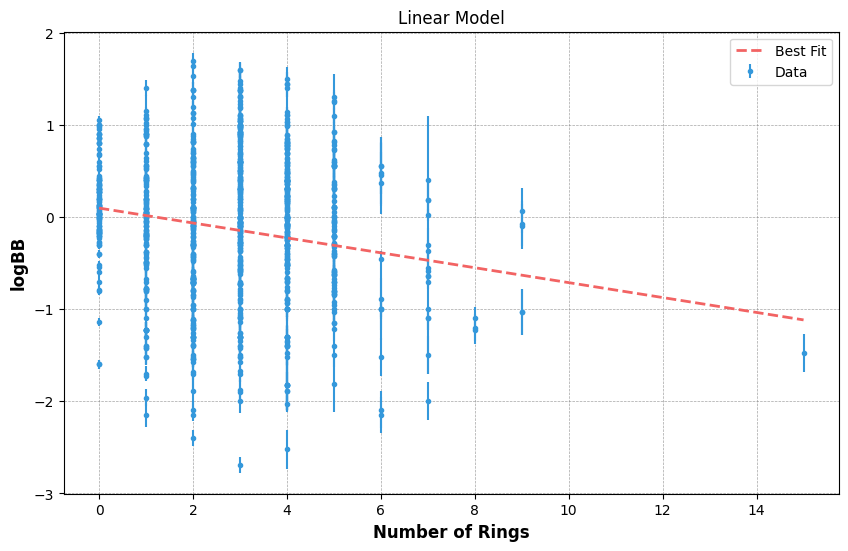

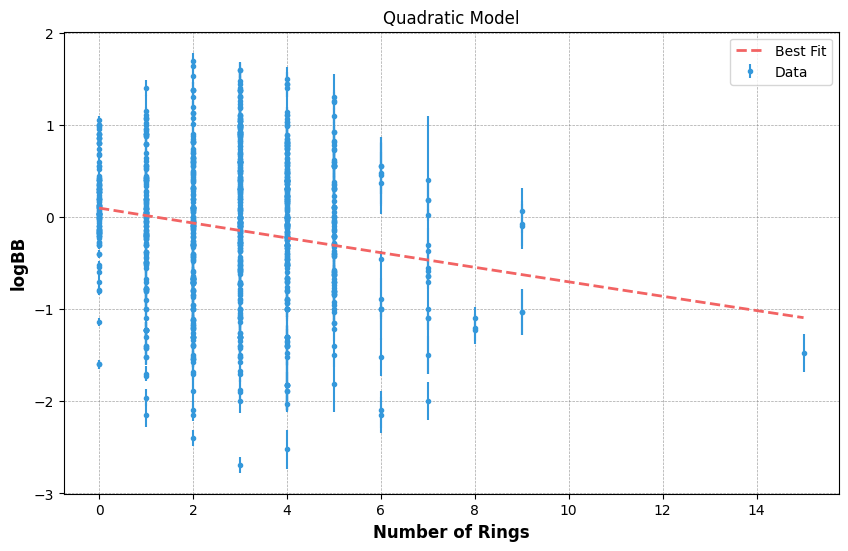

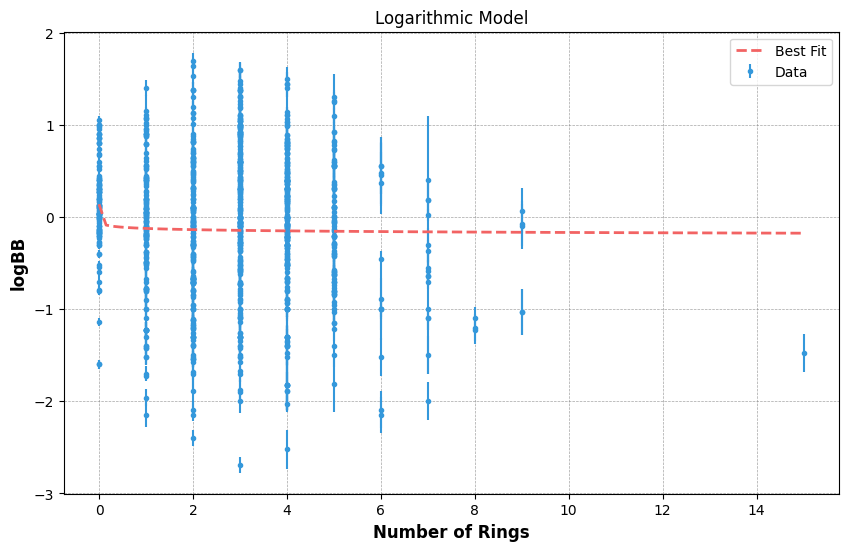

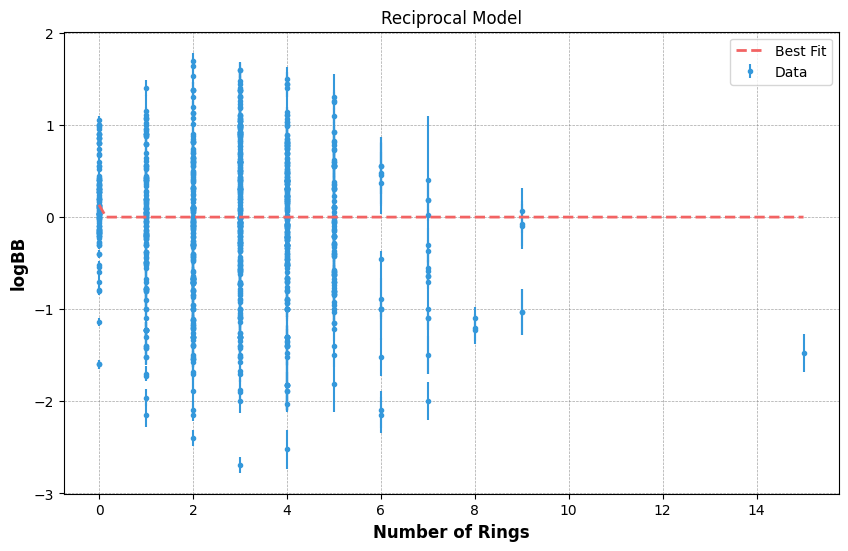

In [89]:
# fit models to logBB vs. number of rings
x_value = data['num_rings'].to_numpy()
fitparams, fiterrs = mycurvefit(linear_model, x_value, y_value, y_error, 'Number of Rings', 'logBB', title='Linear Model', plot=True)
fitparams, fiterrs = mycurvefit(quadratic_model, x_value, y_value, y_error, 'Number of Rings', 'logBB', title='Quadratic Model', plot=True)
fitparams, fiterrs = mycurvefit(logarithmic_model, x_value, y_value, y_error, 'Number of Rings', 'logBB', title='Logarithmic Model', plot=True)
fitparams, fiterrs = mycurvefit(reciprocal_model, x_value, y_value, y_error, 'Number of Rings', 'logBB', title='Reciprocal Model', plot=True)

We repeat this process for number of rotatable bonds.

Best Fit Parameters:

	 Independent Variable: Number of Rotatable Bonds
	 Dependent Variable: logBB
	 Model: Linear Model
	 P1 =  -0.0542 +/- 0.0007
	 P2 =  0.12962 +/- 0.00338

 Fit Metrics:

	 Degrees of freedom (N-d):  1056
	 Reduced Chi Squared = 69.456

Best Fit Parameters:

	 Independent Variable: Number of Rotatable Bonds
	 Dependent Variable: logBB
	 Model: Quadratic Model
	 P1 =  -0.00067 +/- 9e-05
	 P2 =  -0.0453 +/- 0.00137
	 P3 =  0.11424 +/- 0.00395

 Fit Metrics:

	 Degrees of freedom (N-d):  1055
	 Reduced Chi Squared = 69.468

Best Fit Parameters:

	 Independent Variable: Number of Rotatable Bonds
	 Dependent Variable: logBB
	 Model: Logarithmic Model
	 P1 =  -0.01787 +/- 0.0004
	 P2 =  -0.08749 +/- 0.00242

 Fit Metrics:

	 Degrees of freedom (N-d):  1056
	 Reduced Chi Squared = 73.229

Best Fit Parameters:

	 Independent Variable: Number of Rotatable Bonds
	 Dependent Variable: logBB
	 Model: Reciprocal Model
	 P1 =  0.0 +/- 0.0

 Fit Metrics:

	 Degrees of freedom (N

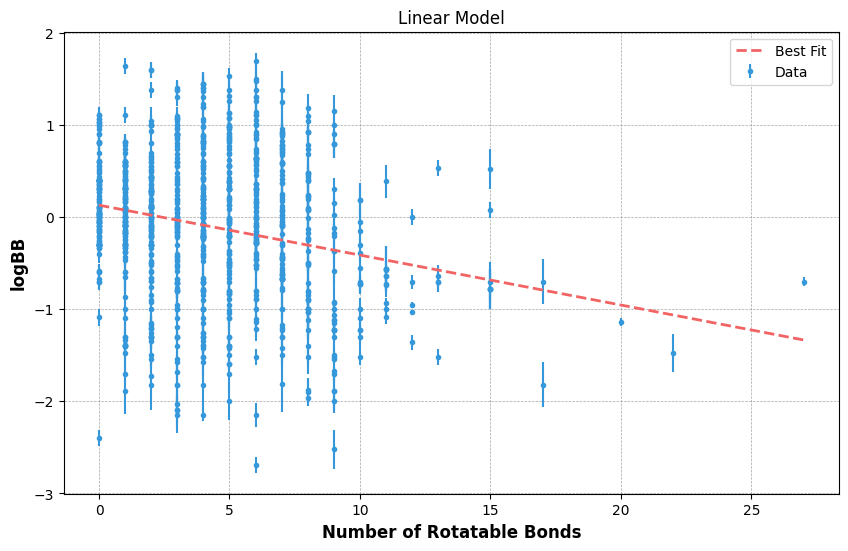

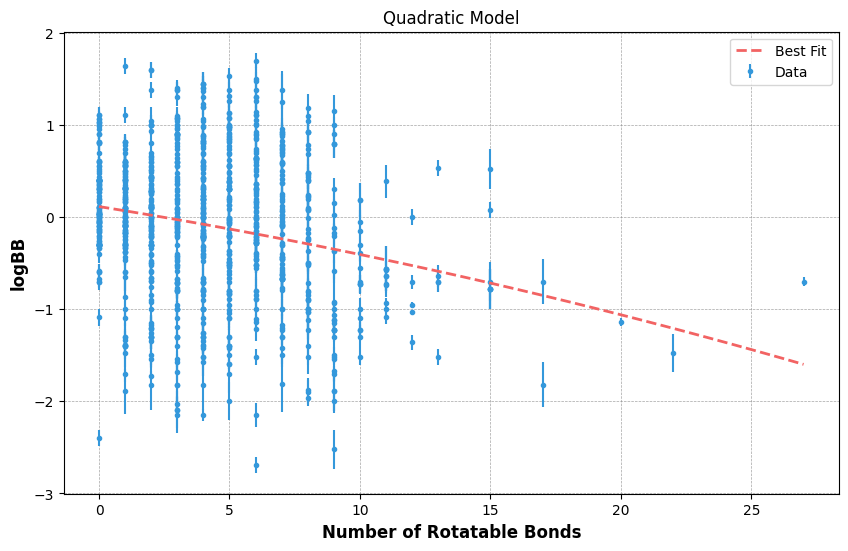

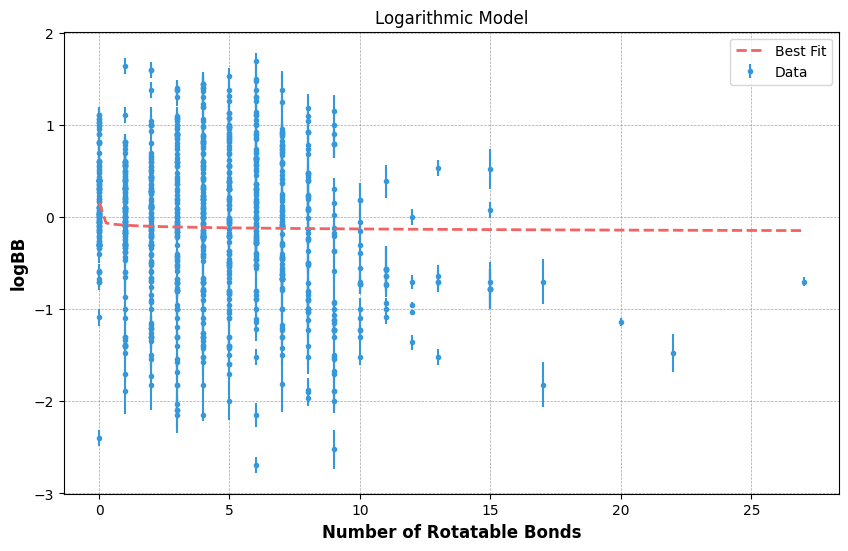

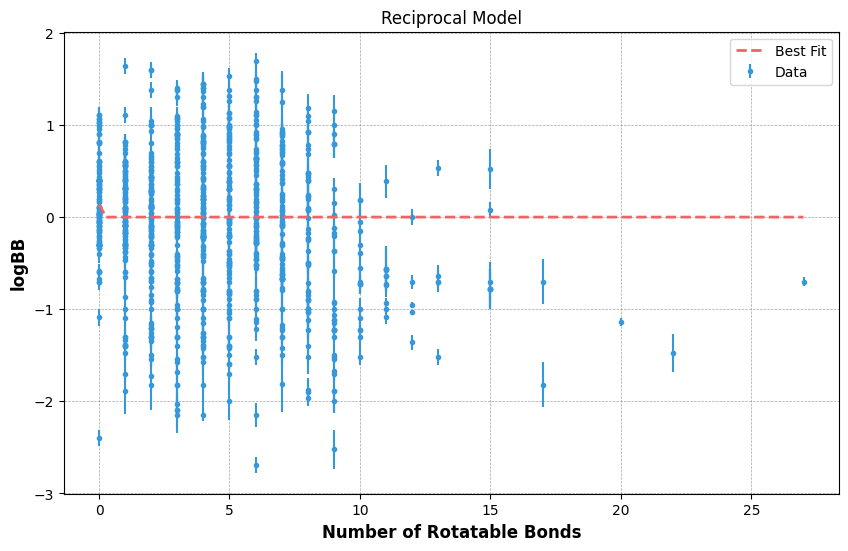

In [90]:
# fit models to logBB vs. number of rotatable bonds
x_value = data['num_rotatable_bonds'].to_numpy()
fitparams, fiterrs = mycurvefit(linear_model, x_value, y_value, y_error, 'Number of Rotatable Bonds', 'logBB', title='Linear Model', plot=True)
fitparams, fiterrs = mycurvefit(quadratic_model, x_value, y_value, y_error, 'Number of Rotatable Bonds', 'logBB', title='Quadratic Model', plot=True)
fitparams, fiterrs = mycurvefit(logarithmic_model, x_value, y_value, y_error, 'Number of Rotatable Bonds', 'logBB', title='Logarithmic Model', plot=True)
fitparams, fiterrs = mycurvefit(reciprocal_model, x_value, y_value, y_error, 'Number of Rotatable Bonds', 'logBB', title='Reciprocal Model', plot=True)

Finally, we repeat this process for the number of hydrogen bonds donors and acceptors.

Best Fit Parameters:

	 Independent Variable: Number of Hydrogen Bond Donors
	 Dependent Variable: logBB
	 Model: Linear Model
	 P1 =  -0.24314 +/- 0.00173
	 P2 =  0.22366 +/- 0.00308

 Fit Metrics:

	 Degrees of freedom (N-d):  1056
	 Reduced Chi Squared = 56.382

Best Fit Parameters:

	 Independent Variable: Number of Hydrogen Bond Donors
	 Dependent Variable: logBB
	 Model: Quadratic Model
	 P1 =  0.00964 +/- 0.00049
	 P2 =  -0.28923 +/- 0.00291
	 P3 =  0.2466 +/- 0.0033

 Fit Metrics:

	 Degrees of freedom (N-d):  1055
	 Reduced Chi Squared = 56.069

Best Fit Parameters:

	 Independent Variable: Number of Hydrogen Bond Donors
	 Dependent Variable: logBB
	 Model: Logarithmic Model
	 P1 =  -0.03654 +/- 0.00033
	 P2 =  -0.25183 +/- 0.00292

 Fit Metrics:

	 Degrees of freedom (N-d):  1056
	 Reduced Chi Squared = 63.655

Best Fit Parameters:

	 Independent Variable: Number of Hydrogen Bond Donors
	 Dependent Variable: logBB
	 Model: Reciprocal Model
	 P1 =  0.0 +/- 0.0

 Fit Metrics:



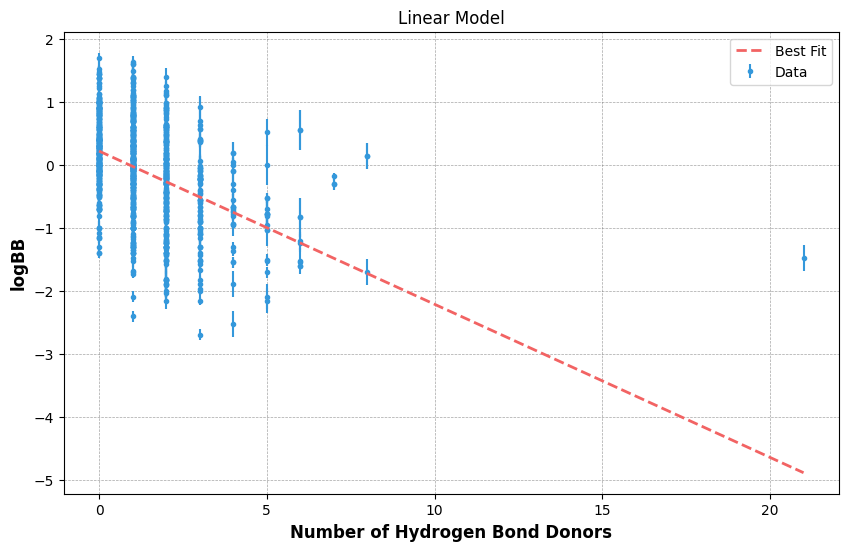

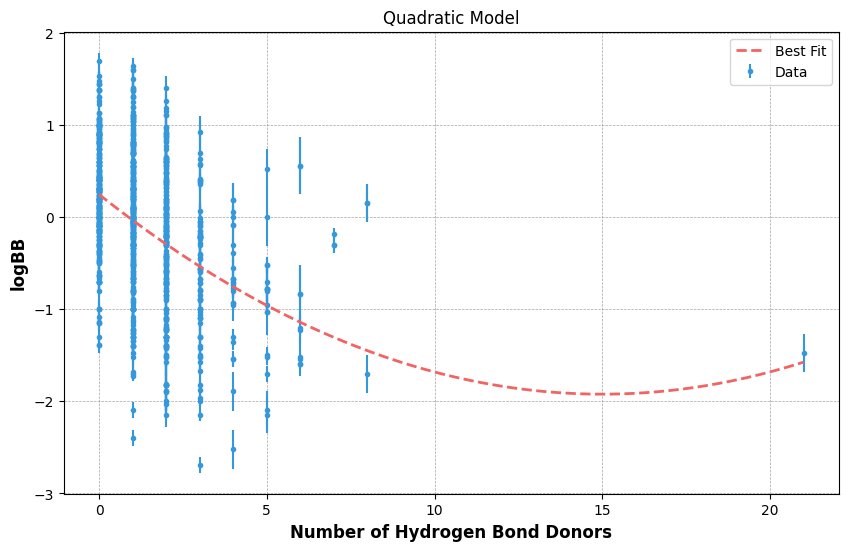

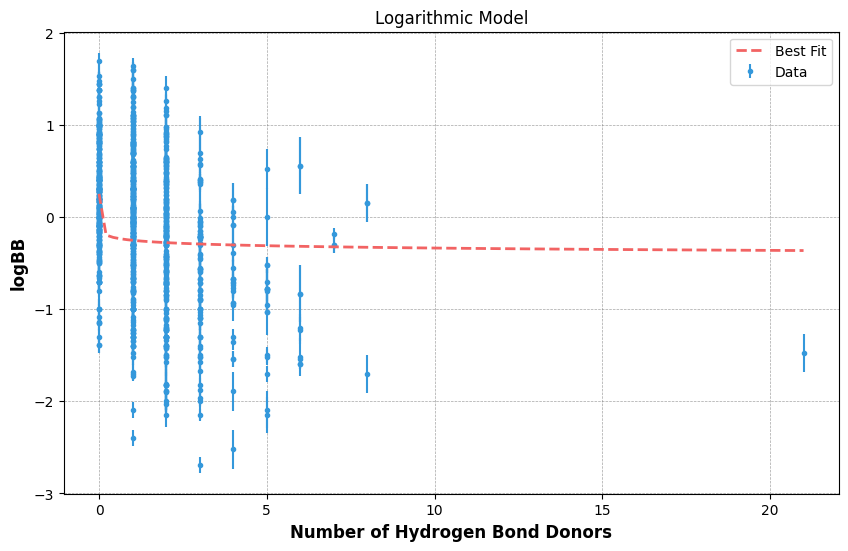

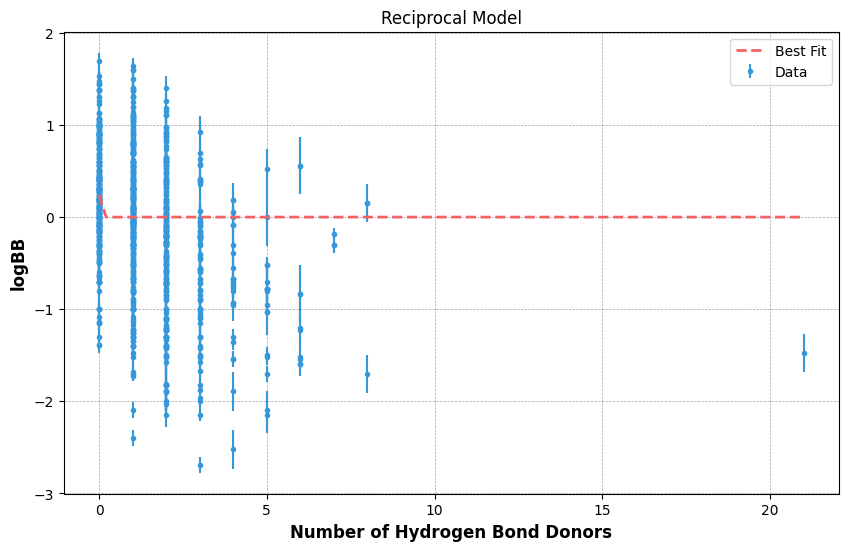

In [91]:
# fit models to logBB vs. number of hydrogen bond donors
x_value = data['num_h_donors'].to_numpy()
fitparams, fiterrs = mycurvefit(linear_model, x_value, y_value, y_error, 'Number of Hydrogen Bond Donors', 'logBB', title='Linear Model', plot=True)
fitparams, fiterrs = mycurvefit(quadratic_model, x_value, y_value, y_error, 'Number of Hydrogen Bond Donors', 'logBB', title='Quadratic Model', plot=True)
fitparams, fiterrs = mycurvefit(logarithmic_model, x_value, y_value, y_error, 'Number of Hydrogen Bond Donors', 'logBB', title='Logarithmic Model', plot=True)
fitparams, fiterrs = mycurvefit(reciprocal_model, x_value, y_value, y_error, 'Number of Hydrogen Bond Donors', 'logBB', title='Reciprocal Model', plot=True)

Again, for number of hydrogen bond acceptors.

Best Fit Parameters:

	 Independent Variable: Number of Hydrogen Bond Acceptors
	 Dependent Variable: logBB
	 Model: Linear Model
	 P1 =  -0.13224 +/- 0.00093
	 P2 =  0.3613 +/- 0.00378

 Fit Metrics:

	 Degrees of freedom (N-d):  1056
	 Reduced Chi Squared = 56.173

Best Fit Parameters:

	 Independent Variable: Number of Hydrogen Bond Acceptors
	 Dependent Variable: logBB
	 Model: Quadratic Model
	 P1 =  0.00371 +/- 0.00018
	 P2 =  -0.16636 +/- 0.00187
	 P3 =  0.40912 +/- 0.00441

 Fit Metrics:

	 Degrees of freedom (N-d):  1055
	 Reduced Chi Squared = 55.808

Best Fit Parameters:

	 Independent Variable: Number of Hydrogen Bond Acceptors
	 Dependent Variable: logBB
	 Model: Logarithmic Model
	 P1 =  -0.04297 +/- 0.00043
	 P2 =  -0.11071 +/- 0.00239

 Fit Metrics:

	 Degrees of freedom (N-d):  1056
	 Reduced Chi Squared = 65.611

Best Fit Parameters:

	 Independent Variable: Number of Hydrogen Bond Acceptors
	 Dependent Variable: logBB
	 Model: Reciprocal Model
	 P1 =  0.0 +/- 0.0

 F

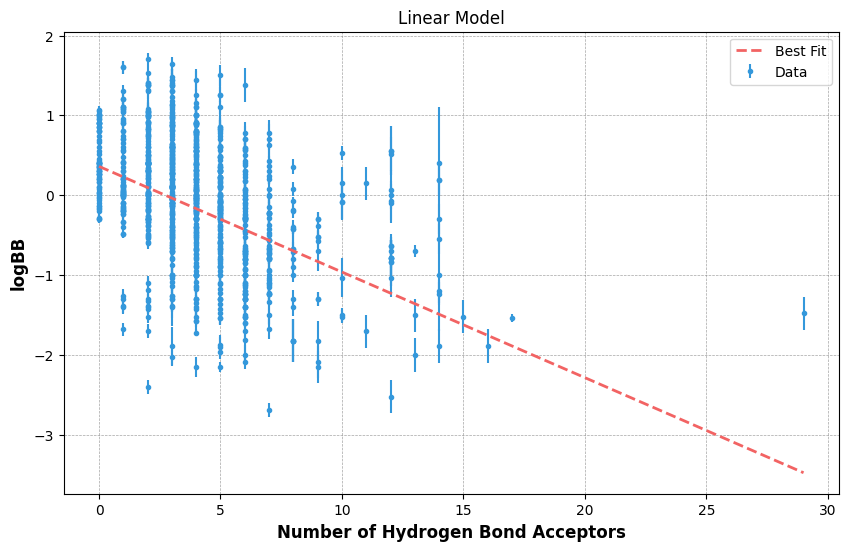

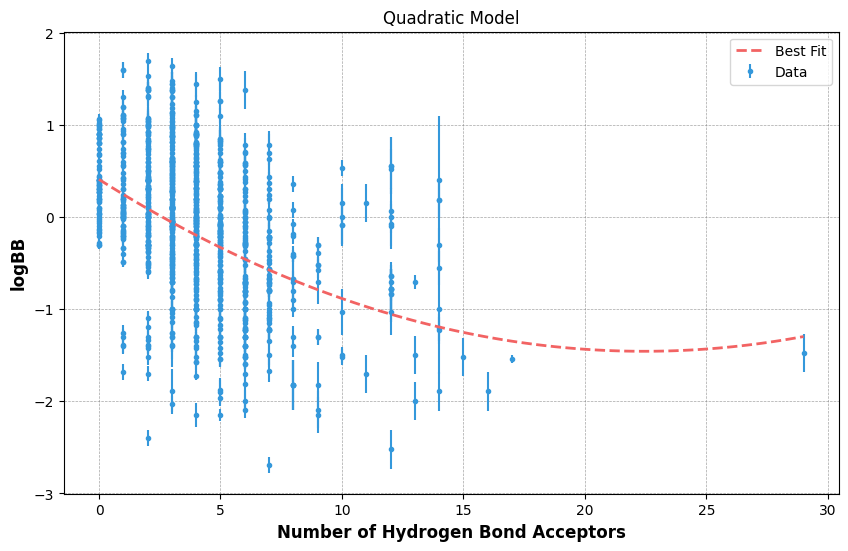

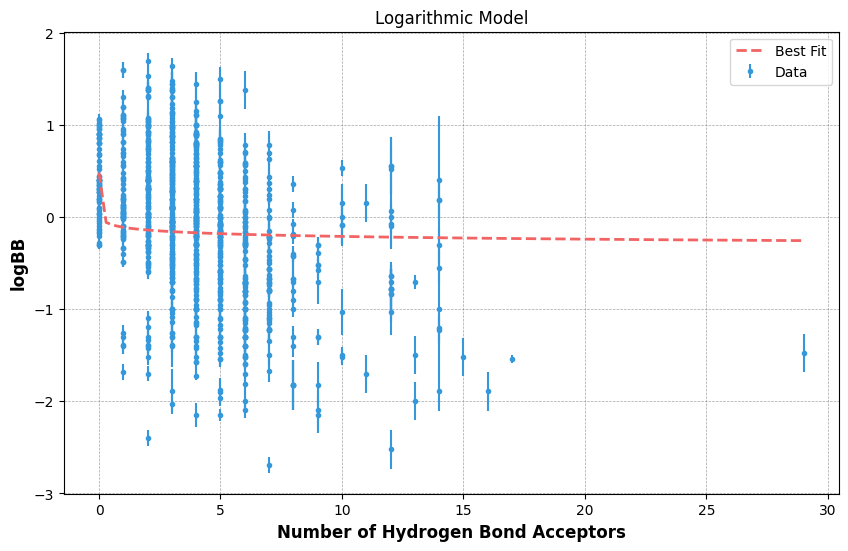

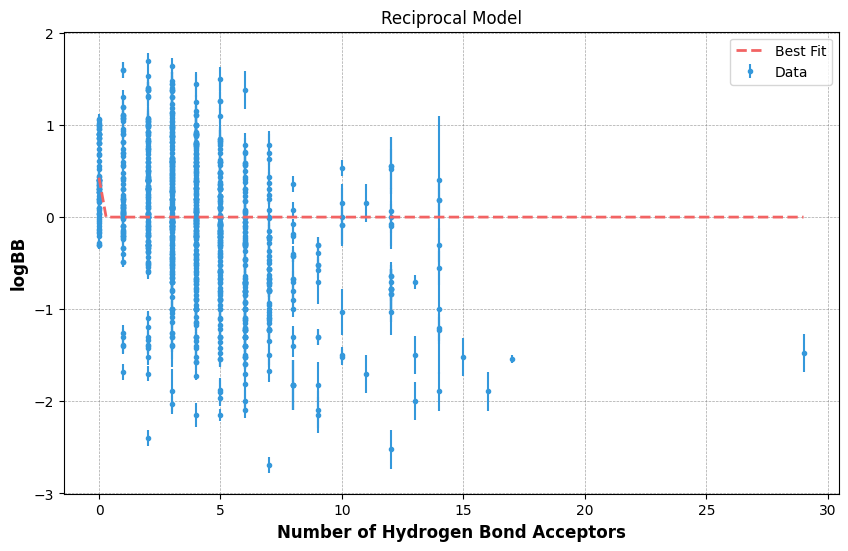

In [92]:
# fit models to logBB vs. number of hydrogen bond acceptors
x_value = data['num_h_acceptors'].to_numpy()
fitparams, fiterrs = mycurvefit(linear_model, x_value, y_value, y_error, 'Number of Hydrogen Bond Acceptors', 'logBB', title='Linear Model', plot=True)
fitparams, fiterrs = mycurvefit(quadratic_model, x_value, y_value, y_error, 'Number of Hydrogen Bond Acceptors', 'logBB', title='Quadratic Model', plot=True)
fitparams, fiterrs = mycurvefit(logarithmic_model, x_value, y_value, y_error, 'Number of Hydrogen Bond Acceptors', 'logBB', title='Logarithmic Model', plot=True)
fitparams, fiterrs = mycurvefit(reciprocal_model, x_value, y_value, y_error, 'Number of Hydrogen Bond Acceptors', 'logBB', title='Reciprocal Model', plot=True)

# Discussion and Conclusion

Here, we fit several models to the data to investigate the relationships between BBB permeability and molecular properties such as molecular weight, number of heavy atoms, number of rings, number of rotatable bonds, and number of hydrogen bond donors and acceptors.

### Molecular Weight
When investigating the relationship between molecular weight and BBB-permeability, we found little difference between the linear and quadratic models, with $\chi^2_{red}$ values of $66.752$ and $66.721$. Other models, such as logarithmic and reciprocal functions, have $\chi^2_{red}$ values of $69.863$ and $75.629$, respectively. Since all $\chi^2_{red}$ values are $\gg 1$, the linear, quadratic, logarithmic, and reciprocal models all do not explain the data.

However, the linear model is given by the equation $y = -0.00147x + 0.32189$, where $y$ is logBB and $x$ is the molecular weight. This indicates that there is a negative correlation between molecular weight and BBB permeability, which is consistent with the literature and with our intuition: as the size of a molecule increases, it is less likely to cross the BBB. The uncertainties on our measurements are small: the measured slope is $-0.00147 \pm 2 \times 10^{-5}$ and the measured intercept is $0.32189 \pm 0.00468$. We found similar results for other variables of interest.

### Number of Heavy Atoms
When investigating the relationship between number of heavy atoms and BBB-permeability, we found little correlation with our given models. For the linear model, with a function of $y = -0.02004x + 0.29819$, the $\chi^2_{red}$ value is $66.854$. For the quadratic model, the $\chi^2_{red}$ value is $75.579$. For the logarithmic model, the $\chi^2_{red}$ value is $70.088$. For the reciprocal model, the $\chi^2_{red}$ value is $75.579$. While the smallest $\chi^2_{red}$ value out of these models (linear has the smallest, with a value of $66.854$) is $\gg 1$, the negative slope of the linear function makes sense: since the number of heavy atoms is correlated with molecular weight and molecular size, we expect molecules with increased numbers of heavy atoms to have decreased BBB-permeability. 

### Number of Rings 
When investigating the relationship between number of rings and BBB-permeability, we found little correlation with our given models. For the linear model, with a function of $y = -0.08095x + 0.00137$, the $\chi^2_{red}$ value is $71.826$. For the quadratic model, the $\chi^2_{red}$ value is $75.07$. For the logarithmic model, the $\chi^2_{red}$ value is $72.355$. For the reciprocal model, the $\chi^2_{red}$ value is $74.79$. While the smallest $\chi^2_{red}$ value out of these models (linear has the smallest) is $\gg 1$, the negative slope of the linear function makes sense. The presence of more rings is correlated with greater molecular size and weight; therefore, our results are consistent with the literature and intuition: as ring count and therefore molecular size increases, a molecule would be less likely to cross the BBB. 

### Number of Rotatable Bonds
When investigating the relationship between number of rotatable bonds and BBB-permeability, we found little minimum correlation with our given models. For the linear model, with a function of $y = -0.0542x + 0.0007$, the $\chi^2_{red}$ value is $69.456$. For quadratic model, the $\chi^2_{red}$ value is $75.07$. For the logarithmic model, the $\chi^2_{red}$ value is $73.229$. For the reciprocal model, the $\chi^2_{red}$ value is $75.07$. On initial thought, this is counterintuitive, since we expect the number of rotatable bonds of a molecule to correlate with increased flexibility and number of possible conformations, and therefore perhaps with increased capacity to bind to a BBB transporter and traverse the BBB. However, we reason that larger molecules often possess more rotatable bonds; therefore, increased number of rotatable bonds is also correlated with increased molecular size. Based on previous intuition and the literature, the negative slope in the fitted linear function thus makes sense. 

### Number of Hydrogen Bond Donors and Acceptors
When investigating the relationship between number of hydrogen bond donors and BBB-permeability, we found little correlation with our models. The linear model, with a function of $y = -0.24314x + 0.22366$, has a $\chi^2_{red}$ value of $56.382$. The quadratic model has a $\chi^2_{red}$ value of $56.069$, the logarithmic model has a $\chi^2_{red}$ value of $63.655$, and the reciprocal model has a $\chi^2_{red}$ value of $71.683$. All models have $\chi^2_{red}$ values $\gg 1$, indicating poor fit. However, as the linear and quadratic models fit best, we intepret the negative slope to mean as the number of hydrogen bond donors increases, BBB-permeability decreases. This makes sense because molecules with hydrogen bonds are polar, so they cannot naturally pass through the blood-brain barrier.

When investigating the relationship between number of hydrogen bond acceptors and BBB-permeability, we also found little correlation with our models. The linear model, with a function of $y = -0.133224x + 0.3613$, has a $\chi^2_{red}$ value of $56.173$. The quadratic model has a $\chi^2_{red}$ value of $55.808$, the logarithmic model has a $\chi^2_{red}$ value of $65.611$, and the reciprocal model has a $\chi^2_{red}$ value of $70.725$. Again, all models have $\chi^2_{red}$ values $\gg 1$, indicating poor fit. The linear and quadratic model fit best, so we can intepret the negative slope to mean as the number of hydrogen bond acceptors increases, BBB-permeability decreses. Similarly to hydrogen bond donor count, this makes sense because molecules with hydrogen bonds are polar, so they are excluded from passage through the blood-brain barrier.

Thus, we conclude that large macromolecules are excluded from the brain; however, our simplistic linear, quadratic, logarithmic, and reciprocal models are insufficient to explain the relationship between molecular properties – such as molecular weight, number of rotatable bonds, number of heavy atoms, number of rings, number of rotatable bonds, and number of hydrogen bond donors and acceptors – and BBB-permeability. 

# References

1. Abbott, N. J., Patabendige, A. A. K., Dolman, D. E. M., Yusof, S. R. & Begley, D. J. Structure and function of the blood–brain barrier. *Neurobiology of Disease* **37**, 13–25 (2010).

2. Abbott, N. J., Rönnbäck, L. & Hansson, E. Astrocyte–endothelial interactions at the blood–brain barrier. *Nat Rev Neurosci* **7**, 41–53 (2006).

3. Daneman, R. & Prat, A. The Blood–Brain Barrier. *Cold Spring Harb Perspect Biol* **7**, a020412 (2015).

4. Iadecola, C. The neurovascular unit coming of age: a journey through neurovascular coupling in health and disease. *Neuron* **96**, 17–42 (2017).

5. Langen, U. H., Ayloo, S. & Gu, C. Development and Cell Biology of the Blood-Brain Barrier. *Annual Review of Cell and Developmental Biology* **35**, 591–613 (2019).

6. Meng, F., Xi, Y., Huang, J. & Ayers, P. W. A curated diverse molecular database of blood-brain barrier permeability with chemical descriptors. *Sci Data* **8**, 289 (2021).

6. Obermeier, B., Daneman, R. & Ransohoff, R. M. Development, maintenance and disruption of the blood-brain barrier. *Nat Med* **19**, 1584–1596 (2013).

7. Wu, D. et al. The blood–brain barrier: structure, regulation, and drug delivery. *Sig Transduct Target Ther* **8**, 1–27 (2023).